# Analise de Fairness (Equidade)
## Deteccao de Vies em Modelos de Credit Scoring

Este notebook analisa se o modelo de credit scoring apresenta vieses em relacao a:
- **Idade**: Discriminacao contra jovens ou idosos
- **Genero**: Disparidade entre homens e mulheres

### Por que Fairness importa?

| Aspecto | Impacto |
|---------|--------|
| **Regulatorio** | LGPD, BACEN exigem transparencia |
| **Reputacional** | Discriminacao gera dano de imagem |
| **Etico** | Decisoes justas sao um imperativo moral |

---
## 1. Configuracao

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from credit_scoring.data.loader import load_german_credit
from credit_scoring.models.train import load_model
from credit_scoring.fairness.analysis import (
    create_sensitive_features,
    analyze_fairness,
    plot_fairness_comparison,
    print_fairness_report,
)

print("Bibliotecas carregadas!")

Bibliotecas carregadas!


In [2]:
# Carregar dados e modelo
X, y = load_german_credit(save_raw=False)

# Carregar modelo treinado
model = load_model('../models/best_model_optuna.joblib')

print(f"Dataset: {X.shape[0]} amostras")
print(f"Modelo carregado: {type(model).__name__}")

Dataset: 1000 amostras
Modelo carregado: Pipeline


---
## 2. Atributos Sensiveis

Identificamos os atributos que podem levar a discriminacao:

In [3]:
# Criar grupos sensiveis
sensitive = create_sensitive_features(X)

print("Distribuicao por Idade:")
print(sensitive['age_group'].value_counts())
print("\nDistribuicao por Genero:")
print(sensitive['gender'].value_counts())

Distribuicao por Idade:
age_group
Middle (30-50)    476
Young (<30)       411
Senior (>50)      113
Name: count, dtype: int64

Distribuicao por Genero:
gender
Male      690
Female    310
Name: count, dtype: int64


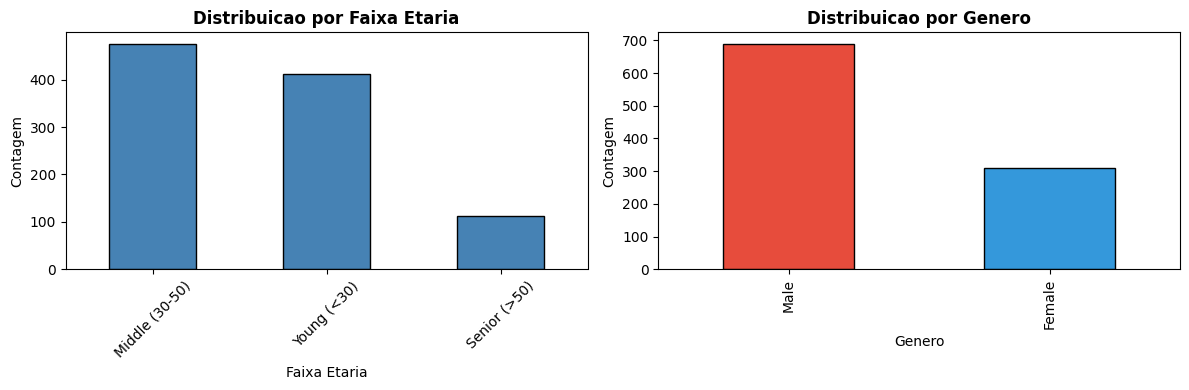

In [4]:
# Visualizar distribuicao
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sensitive['age_group'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Distribuicao por Faixa Etaria', fontweight='bold')
axes[0].set_xlabel('Faixa Etaria')
axes[0].set_ylabel('Contagem')
axes[0].tick_params(axis='x', rotation=45)

sensitive['gender'].value_counts().plot(kind='bar', ax=axes[1], color=['#e74c3c', '#3498db'], edgecolor='black')
axes[1].set_title('Distribuicao por Genero', fontweight='bold')
axes[1].set_xlabel('Genero')
axes[1].set_ylabel('Contagem')

plt.tight_layout()
plt.savefig('../reports/figures/fairness_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Analise de Fairness

In [5]:
# Executar analise completa
fairness_results = analyze_fairness(
    model=model,
    X=X,
    y_true=y,
    sensitive_columns=['age_group', 'gender']
)


[*] Analyzing fairness for: age_group



[*] Analyzing fairness for: gender


In [6]:
# Relatorio detalhado
print_fairness_report(fairness_results)


FAIRNESS ANALYSIS REPORT

Sensitive Attribute: age_group

Demographic Parity:
  Difference: 0.1472
  Ratio: 0.7062

Equalized Odds:
  Difference: 0.1245
  Ratio: 0.6442

Selection Rate by Group:
  Middle (30-50): 0.3676
  Senior (>50): 0.3540
  Young (<30): 0.5012

Verdict: MODERATE BIAS (0.1 <= DPD < 0.2)

Sensitive Attribute: gender

Demographic Parity:
  Difference: 0.1098
  Ratio: 0.7789

Equalized Odds:
  Difference: 0.0927
  Ratio: 0.7993

Selection Rate by Group:
  Female: 0.4968
  Male: 0.3870

Verdict: MODERATE BIAS (0.1 <= DPD < 0.2)



---
## 4. Visualizacoes

[SAVE] Fairness plot saved to: ../reports/figures/fairness_selection_rate.png


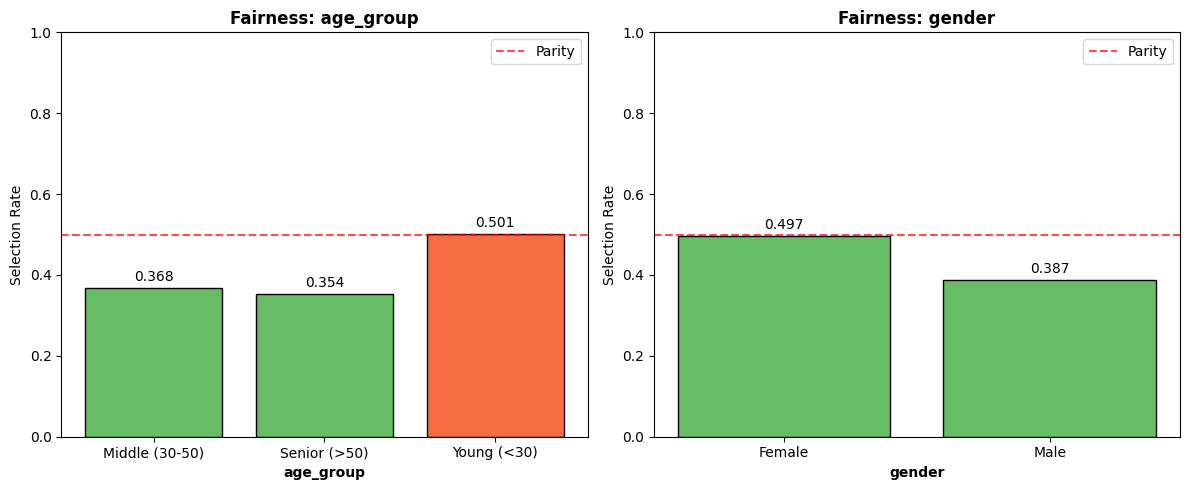

In [7]:
# Grafico de Selection Rate
fig = plot_fairness_comparison(
    fairness_results,
    metric='selection_rate',
    save_path='../reports/figures/fairness_selection_rate.png'
)
plt.show()

[SAVE] Fairness plot saved to: ../reports/figures/fairness_fpr.png


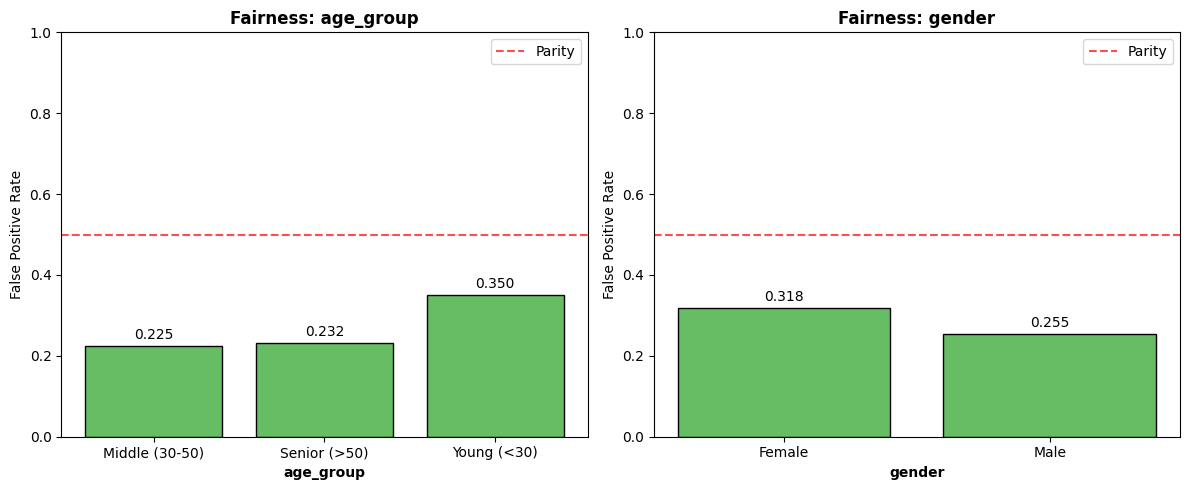

In [8]:
# Grafico de False Positive Rate
fig = plot_fairness_comparison(
    fairness_results,
    metric='false_positive_rate',
    save_path='../reports/figures/fairness_fpr.png'
)
plt.show()

---
## 5. Metricas de Fairness

### Definicoes:

| Metrica | Definicao | Meta |
|---------|-----------|------|
| **Demographic Parity** | P(Y=1 \| A=a) = P(Y=1 \| A=b) | Difference < 0.1 |
| **Equalized Odds** | TPR e FPR iguais entre grupos | Difference < 0.1 |
| **Selection Rate** | Taxa de aprovacao por grupo | Similar entre grupos |

In [9]:
# Resumo das metricas
summary = []
for attr, results in fairness_results.items():
    summary.append({
        'Atributo': attr,
        'Demographic Parity Diff': results['demographic_parity_difference'],
        'Demographic Parity Ratio': results['demographic_parity_ratio'],
        'Equalized Odds Diff': results['equalized_odds_difference'],
        'Equalized Odds Ratio': results['equalized_odds_ratio'],
    })

summary_df = pd.DataFrame(summary)
print("\nRESUMO DAS METRICAS DE FAIRNESS")
print("=" * 70)
print(summary_df.to_string(index=False))


RESUMO DAS METRICAS DE FAIRNESS
 Atributo  Demographic Parity Diff  Demographic Parity Ratio  Equalized Odds Diff  Equalized Odds Ratio
age_group                 0.147234                  0.706246             0.124458              0.644213
   gender                 0.109818                  0.778938             0.092704              0.799317


---
## 6. Interpretacao e Recomendacoes

In [10]:
print("=" * 70)
print("CONCLUSOES DA ANALISE DE FAIRNESS")
print("=" * 70)

for attr, results in fairness_results.items():
    dpd = abs(results['demographic_parity_difference'])
    
    print(f"\n{attr.upper()}:")
    if dpd < 0.1:
        print("  Status: FAIR")
        print("  O modelo nao apresenta vies significativo.")
    elif dpd < 0.2:
        print("  Status: ATENCAO")
        print("  Vies moderado detectado. Considerar mitigacao.")
    else:
        print("  Status: CRITICO")
        print("  Vies significativo! Necessaria intervencao.")

print("\n" + "=" * 70)
print("RECOMENDACOES:")
print("  1. Monitorar metricas de fairness em producao")
print("  2. Considerar tecnicas de mitigacao (reweighting, threshold adjustment)")
print("  3. Documentar analise para compliance regulatorio")
print("=" * 70)

CONCLUSOES DA ANALISE DE FAIRNESS

AGE_GROUP:
  Status: ATENCAO
  Vies moderado detectado. Considerar mitigacao.

GENDER:
  Status: ATENCAO
  Vies moderado detectado. Considerar mitigacao.

RECOMENDACOES:
  1. Monitorar metricas de fairness em producao
  2. Considerar tecnicas de mitigacao (reweighting, threshold adjustment)
  3. Documentar analise para compliance regulatorio


In [11]:
# Salvar resultados
summary_df.to_csv('../reports/fairness_metrics.csv', index=False)
print("Metricas salvas em: reports/fairness_metrics.csv")

Metricas salvas em: reports/fairness_metrics.csv
